#  AI Pathologist 
## For Invasive Ductal Carcinoma Detection

### Background

Invasive ductal carcinoma (IDC), also known as infiltrating ductal carcinoma, is cancer that began growing in a milk duct and has invaded the fibrous or fatty tissue of the breast outside of the duct. 

Invasive means that the cancer has “invaded” or spread to the surrounding breast tissues. 

Ductal means that the cancer began in the milk ducts, which are the “pipes” that carry milk from the milk-producing lobules to the nipple. 

Carcinoma refers to any cancer that begins in the skin or other tissues that cover internal organs, such as breast tissue. 

All together, “invasive ductal carcinoma” refers to cancer that has broken through the walls of the milk ducts and begun to invade the tissues of the breast. 

Over time, invasive ductal carcinoma can spread to the lymph nodes and possibly to other areas of the body. 

IDC starts in the cells that line a milk duct in the breast, breaks through the wall of the duct, and grows into the nearby breast tissues. 

At this point, it may be able to spread (metastasize) to other parts of the body through the lymph system and bloodstream.

According to the American Cancer Society, about two-thirds of women are 55 or older when they are diagnosed with invasive breast cancer. 

Invasive ductal carcinoma also affects men.

### Problem

More women are diagnosed with breast cancer than any other cancer, besides skin cancer. 

As with any breast cancer, there may be no signs or symptoms. 

Invasive ductal carcinoma is the most common form of invasive breast cancer and represents 80 percent of breast cancer cases/diagnoses.

A mammogram may reveal a suspicious mass, which will lead to further testing including biopsies, which involve taking out some or all of the abnormal-looking tissue for examination by a pathologist (a doctor trained to diagnose cancer from biopsy samples) under a microscope. 

More than 1 million women have breast biopsies each year in the United States. 

About 20 percent of these biopsies yield a diagnosis of breast cancer. 

This year, an estimated 268,600 women in the United States will be diagnosed with invasive breast cancer and 2,670 men in the United States will be diagnosed with breast cancer.

It is estimated that 42,260 deaths (41,760 women and 500 men) from breast cancer will occur this year. 

### Data

I used the 1.64GB breast histopathology image dataset provided by Kaggle: https://www.kaggle.com/paultimothymooney/breast-histopathology-images 

The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x.

From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). 

These pictures could be fed into an algorithm which would be able to classify whether invasive ductal carcinoma is present in an image.

### References

Breast Biopsy - 
https://www.choosingwisely.org/patient-resources/breast-biopsy/

Breast Cancer - Statistics - 
https://www.cancer.net/cancer-types/breast-cancer/statistics

Breast Histopathology Images - Paul Mooney - 
https://www.kaggle.com/paultimothymooney/breast-histopathology-images

Information and Resources About For Cancer: Breast, Colon, Lung, Prostate, Skin - 
https://www.cancer.org/

Invasive Ductal Carcinoma: Diagnosis, Treatment, and More - 
https://www.breastcancer.org/symptoms/types/idc

Invasive Ductal Carcinoma (idc) Breast Cancer: Johns Hopkins Breast Center - Ken Brown -https://www.hopkinsmedicine.org/breast_center/breast_cancers_other_conditions/invasive_ductal_carcinoma.html

## Imports and Dependencies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns
import os
from os.path import isfile
import tensorflow as tf
import keras
from keras.utils import np_utils
import itertools
import shutil
np.random.seed(42)
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
tf.__version__

'2.3.0'

In [3]:
tf.keras.__version__

'2.4.0'

## Data Extraction

### Unzip uploaded file

In [4]:
# upload zipped 'IDC_regular_ps50_idx5.zip' before this step
!unzip -o -q 'IDC_regular_ps50_idx5.zip'

# -f  freshen existing files, create none
# -n  never overwrite existing files
# -q  quiet mode (-qq => quieter)
# -o  overwrite files WITHOUT prompting

unzip:  cannot find or open IDC_regular_ps50_idx5.zip, IDC_regular_ps50_idx5.zip.zip or IDC_regular_ps50_idx5.zip.ZIP.


### Unzip file directly from Kaggle (saves personal storage and uploads to Colab faster)

A token is required from Kaggle - 'kaggle.json'

To obtain the token, go to kaggle.com > Your Profile (Profile Icon) > My Account > API > Create New API Token

In [5]:
!pip3 -q install kaggle

In [6]:
# upload kaggle token 'kaggle.json'
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ariefbros","key":"964d79f1a6e3e4c58f4e622a24ca1ca8"}'}

In [7]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/kaggle/kaggle.json

chmod: cannot access '/root/kaggle/kaggle.json': No such file or directory


In [8]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

 99% 3.08G/3.10G [01:15<00:00, 33.2MB/s]
100% 3.10G/3.10G [01:15<00:00, 44.0MB/s]


In [9]:
!unzip -o -q 'breast-histopathology-images.zip'
!unzip -o -q 'IDC_regular_ps50_idx5.zip'

# -f  freshen existing files, create none
# -n  never overwrite existing files
# -q  quiet mode (-qq => quieter)
# -o  overwrite files WITHOUT prompting

unzip:  cannot find or open IDC_regular_ps50_idx5.zip, IDC_regular_ps50_idx5.zip.zip or IDC_regular_ps50_idx5.zip.ZIP.


## Copy Data Into Directories

all_images_dir


> 1 (IDC Positive Class)

>> IDC positive images


> 0 (IDC Negative Class)

>> IDC negative images



In [10]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

# Create Positive subdirectory within all images
os.mkdir('all_images_dir/1')
os.mkdir('all_images_dir/0')

In [11]:
# copies all images from their seperate folders into the same 
# folder called all_images_dir


# create a list of all patient id's
# each patient id folder has 2 sub folders --> folder 0 and folder 1

# Example:
    # '10285'
        # '0'
        # '1'

cur_dir = os.getcwd()
patient_list = os.listdir(cur_dir)

for patient in patient_list:
  
  try:
    
    path_0 = str(patient) + '/0'
    path_1 = str(patient) + '/1'

    # create a list of all files in folder 0
    file_list_0 = os.listdir(path_0)
    # create a list of list all file in folder 1
    file_list_1 = os.listdir(path_1)

    # move the 0 images to all_images_dir
    for fname in file_list_0:

        # source path to image
        src = os.path.join(path_0, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, '0', fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    # move the 1 images to all_images_dir
    for fname in file_list_1:

        # source path to image
        src = os.path.join(path_1, fname)
        # destination path to image
        dst = os.path.join(all_images_dir, '1', fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        
  except:
     print(patient, 'cannot be copied into proper folder')

.config cannot be copied into proper folder
breast-histopathology-images.zip cannot be copied into proper folder
IDC_regular_ps50_idx5 cannot be copied into proper folder
all_images_dir cannot be copied into proper folder
sample_data cannot be copied into proper folder


In [12]:
# Check how many images are in each folder

print('Total:', len(os.listdir('all_images_dir/1'))+len(os.listdir('all_images_dir/0')))
print('Positive:', len(os.listdir('all_images_dir/1')))
print('Negative:', len(os.listdir('all_images_dir/0')))

Total: 277524
Positive: 78786
Negative: 198738


## Make Dataframe of Image Info.

In [13]:
# Create a dataframe containing all the information

image_list_1 = os.listdir('all_images_dir/1')
df_data_1 = pd.DataFrame(image_list_1, columns=['image_id'])

image_list_0 = os.listdir('all_images_dir/0')
df_data_0 = pd.DataFrame(image_list_0, columns=['image_id'])

df_data = pd.concat([df_data_1, df_data_0])

In [14]:
df_data.head()

,image_id
0,8864_idx5_x2151_y2051_class1.png
1,15473_idx5_x1751_y701_class1.png
2,13694_idx5_x1201_y1101_class1.png
3,9346_idx5_x751_y1551_class1.png
4,14153_idx5_x701_y1501_class1.png


In [15]:
# Define Helper Functions

# Each file name has this format:
# '14211_idx5_x2401_y1301_class1.png'

def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

# extract the patient id

# create a new column called 'patient_id'
df_data['patient_id'] = df_data['image_id'].apply(extract_patient_id)
# create a new column called 'target'
df_data['target'] = df_data['image_id'].apply(extract_target)

df_data.head()

,image_id,patient_id,target
0,8864_idx5_x2151_y2051_class1.png,8864,1
1,15473_idx5_x1751_y701_class1.png,15473,1
2,13694_idx5_x1201_y1101_class1.png,13694,1
3,9346_idx5_x751_y1551_class1.png,9346,1
4,14153_idx5_x701_y1501_class1.png,14153,1


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Class Distributions')

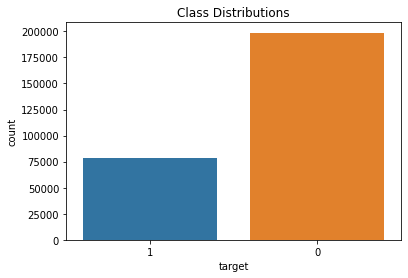

In [16]:
sns.countplot(df_data['target']).set_title('Class Distributions')

## Train/Valid/Test Split

In [17]:
from sklearn.model_selection import train_test_split

y = df_data['target']

_, df_test = train_test_split(df_data, test_size=0.03603, random_state=42, stratify=y)

_, df_val = train_test_split(df_data, test_size=0.0036025, random_state=42, stratify=y)

print('Valid:', df_val.shape[0])
print('Test:', df_test.shape[0])

Valid: 1000
Test: 10000


In [18]:
df_val.head()

,image_id,patient_id,target
121626,14157_idx5_x3301_y1501_class0.png,14157,0
194027,10259_idx5_x2401_y1951_class0.png,10259,0
123961,13693_idx5_x1451_y2351_class0.png,13693,0
21361,16165_idx5_x1351_y951_class1.png,16165,1
56886,12884_idx5_x851_y1151_class0.png,12884,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Valid Class Distributions')

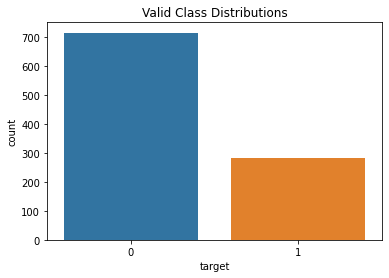

In [19]:
sns.countplot(df_val['target']).set_title('Valid Class Distributions')

In [20]:
df_test.head()

,image_id,patient_id,target
132161,12911_idx5_x2001_y251_class0.png,12911,0
175607,14078_idx5_x801_y1501_class0.png,14078,0
120975,13106_idx5_x2001_y2101_class0.png,13106,0
40149,8867_idx5_x2701_y1701_class0.png,8867,0
131004,14304_idx5_x1401_y251_class0.png,14304,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Test Class Distributions')

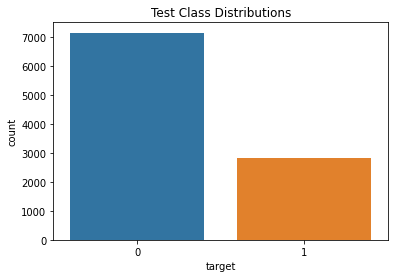

In [21]:
sns.countplot(df_test['target']).set_title('Test Class Distributions')

In [22]:
def identify_train_val_and_test_rows(x):
    # create a list of all the lesion_id's in the val set and test set
    val_list = list(df_val['image_id'])
    test_list = list(df_test['image_id'])
    
    if str(x) in val_list:
        return 'val'
    elif str(x) in test_list:
        return 'test'
    else:
        return 'train'

# create a new colum that is a copy of the image_id column
df_data['train_or_val_or_test'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val_or_test'] = df_data['train_or_val_or_test'].apply(identify_train_val_and_test_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val_or_test'] == 'train']

print('Train:', len(df_train))
print('Valid:', len(df_val))
print('Test:', len(df_test))

Train: 267524
Valid: 1000
Test: 10000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Train Class Distributions')

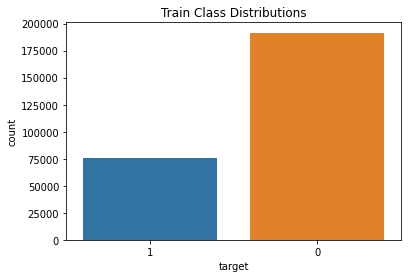

In [23]:
sns.countplot(df_train['target']).set_title('Train Class Distributions')

In [24]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)
df_data.head()

,patient_id,target,train_or_val_or_test
image_id,,,
8864_idx5_x2151_y2051_class1.png,8864,1,train
15473_idx5_x1751_y701_class1.png,15473,1,train
13694_idx5_x1201_y1101_class1.png,13694,1,train
9346_idx5_x751_y1551_class1.png,9346,1,train
14153_idx5_x701_y1501_class1.png,14153,1,train


## Move Train/Valid/Test Images Into Repective Directories

train_dir


> 1 (IDC Positive Class)

>> IDC positive images


> 0 (IDC Negative Class)

>> IDC negative images


val_dir


> 1 (IDC Positive Class)

>> IDC positive images


> 0 (IDC Negative Class)

>> IDC negative images


test_dir


> 1 (IDC Positive Class)

>> IDC positive images


> 0 (IDC Negative Class)

>> IDC negative images

In [25]:
# Make Train, Valid, and Test Folders

# train_dir
train_dir = os.path.join('train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join('val_dir')
os.mkdir(val_dir)

# test_dir
test_dir = os.path.join('test_dir')
os.mkdir(test_dir)


# Create folders within the train, valid, and test folders
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
os.mkdir(os.path.join(train_dir, '1'))
os.mkdir(os.path.join(train_dir, '0'))

# Create new folders inside val_dir
os.mkdir(os.path.join(val_dir, '1'))
os.mkdir(os.path.join(val_dir, '0'))

# Create new folders inside test_dir
os.mkdir(os.path.join(test_dir, '1'))
os.mkdir(os.path.join(test_dir, '0'))

In [26]:
# Get a list of train, val, and test images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])
test_list = list(df_test['image_id'])

# Transfer the train images

for image in train_list:
    
    pat_id = df_data.loc[image,'patient_id']
    label = df_data.loc[image,'target']
    src = pat_id + '/' + label + '/' + image
    
    # destination path to image
    dst = os.path.join(train_dir, label, image)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    pat_id = df_data.loc[image,'patient_id']
    label = df_data.loc[image,'target']
    src = pat_id + '/' + label + '/' + image
    
    # destination path to image
    dst = os.path.join(val_dir, label, image)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
    
    
# Transfer the test images
for image in test_list:
    
    pat_id = df_data.loc[image,'patient_id']
    label = df_data.loc[image,'target']
    src = pat_id + '/' + label + '/' + image
    
    # destination path to image
    dst = os.path.join(test_dir, label, image)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [27]:
print('Train Total:', len(os.listdir('train_dir/1'))+len(os.listdir('train_dir/0')))
print('Valid Total:', len(os.listdir('val_dir/1'))+len(os.listdir('val_dir/0')))
print('Test Total:', len(os.listdir('test_dir/1'))+len(os.listdir('test_dir/0')), '\n')

print('Train Negative:', len(os.listdir('train_dir/0')))
print('Train Positive:', len(os.listdir('train_dir/1')), '\n')

print('Valid Negative:', len(os.listdir('val_dir/0')))
print('Valid Positive:', len(os.listdir('val_dir/1')), '\n')

print('Test Negative:', len(os.listdir('test_dir/0')))
print('Test Positive:', len(os.listdir('test_dir/1')))

Train Total: 267524
Valid Total: 1000
Test Total: 10000 

Train Negative: 191577
Train Positive: 75947 

Valid Negative: 716
Valid Positive: 284 

Test Negative: 7161
Test Positive: 2839


## Make Augmented Images of Underrepresented Class (IDC Positive)

In [28]:
image_size = 100

from keras.preprocessing.image import ImageDataGenerator

# create temporary directories here and delete these directories later
aug_dir = 'aug_dir'
os.mkdir(aug_dir)
# create a dir within the base dir to store images of the same class
img_dir = os.path.join(aug_dir, 'img_dir')
os.mkdir(img_dir)

# list all images in that directory
img_list = os.listdir('train_dir/1')

# copy images from the class all images directory to the image directory
for fname in img_list:
    # source path to image
    src = os.path.join('train_dir/1', fname)
    # destination path to image
    dst = os.path.join(img_dir, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# point to a dir containing the images and not to the images themselves
path = 'aug_dir'
save_path = 'train_dir/1'

# create a data generator
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.125,
    height_shift_range=0.125,
    zoom_range=[1.2, 1.325],
    fill_mode='reflect')

batch_size = 25

aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir=save_path,
                                          save_format='jpg',
                                          target_size=(image_size, image_size),
                                          batch_size=batch_size)

# generate the augmented images and add them to the folder of all images

num_aug_images_wanted = len(os.listdir('train_dir/0')) # total number of images wanted in each class

num_files = len(os.listdir(img_dir))
num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

for i in range(0, num_batches):
  next(aug_datagen)

# delete temporary directory with the raw image files
shutil.rmtree('aug_dir')

Found 75947 images belonging to 1 classes.


In [29]:
# Check how many train images we have in each folder

print('Train Total:', len(os.listdir('train_dir/1'))+len(os.listdir('train_dir/0')))
print('Train Positive:', len(os.listdir('train_dir/1')))
print('Train Negative:', len(os.listdir('train_dir/0')))

Train Total: 383171
Train Positive: 191594
Train Negative: 191577


## Create Train/Valid/Test Batches

In [30]:
train_path = 'train_dir'
valid_path = 'val_dir'
test_path = 'test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
num_test_samples = len(df_test)

train_batch_size = 500
val_batch_size = 500
test_batch_size = 500

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [31]:
class_weights={
    0: 1.0, # negative
    1: 1.0, # postive 
    # make model more sensitive to positive class if necessary
}

## Train Transfer Learning Model Including Benchmark Model's Weights
Transfer Learning Model Had Less Accuracy & Worse Performance

In [32]:
from keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

In [33]:
# Load Pre-Trained Model
from keras.applications.resnet50 import ResNet50
base = ResNet50(include_top=False, weights='imagenet', pooling=None, input_shape=(image_size, image_size, 3))

94773248/94765736 [==============================] - 1s 0us/step


In [34]:
# Build Transfer Learning Model

from keras.models import Model

last = base.output
x = GlobalAveragePooling2D()(last)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
preds = Dense(2, activation='softmax')(x)

transfer = Model(base.input, preds)
transfer.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [35]:
# How many layers Base Model has
print(len(base.layers))

175


In [36]:
# Freeze original layers of Base Model
for layer in base.layers:
    layer.trainable = False

In [37]:
# Compile Transfer Learning Model
from keras import metrics
transfer.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
                             horizontal_flip=True,
                             vertical_flip=True, 
                             fill_mode='nearest')

train_batches_transfer = datagen.flow_from_directory(train_path,
                                                     target_size=(image_size, image_size),
                                                     batch_size=train_batch_size)

valid_batches_transfer = datagen.flow_from_directory(valid_path,
                                                     target_size=(image_size, image_size),
                                                     batch_size=val_batch_size)

test_batches_transfer = datagen.flow_from_directory(test_path,
                                                    target_size=(image_size, image_size),
                                                    batch_size=test_batch_size,
                                                    shuffle=False) # test dataset should not be shuffled

Found 383171 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [39]:
# Checkpointer
from keras.callbacks import ModelCheckpoint
# Checkpointer
checkpointer_transfer = ModelCheckpoint(filepath='breast_histopathology_transfer_best.hdf5', verbose=1, save_best_only=True)

# Train Model
history_transfer = transfer.fit_generator(train_batches_transfer, 
                                       steps_per_epoch=train_steps, 
                                       class_weight=class_weights,
                                       validation_data=valid_batches_transfer,
                                       validation_steps=val_steps,
                                       callbacks=[checkpointer_transfer], 
                                       epochs=10, 
                                       verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
536/536 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8790
Epoch 00001: val_loss improved from inf to 0.32325, saving model to breast_histopathology_transfer_best.hdf5
536/536 [==============================] - 457s 854ms/step - loss: 0.2945 - accuracy: 0.8790 - val_loss: 0.3232 - val_accuracy: 0.8590
Epoch 2/10
536/536 [==============================] - ETA: 0s - loss: 0.2380 - accuracy: 0.8986
Epoch 00002: val_loss improved from 0.32325 to 0.30349, saving model to breast_histopathology_transfer_best.hdf5
536/536 [==============================] - 454s 846ms/step - loss: 0.2380 - accuracy: 0.8986 - val_loss: 0.3035 - val_accuracy: 0.8660
Epoch 3/10
536/536 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.9031
Epoch 00003: val_loss did not improve from 0.30349
536/536 [==============================] - 453s 845ms/step - loss: 0.2291 - accuracy: 0.9031 

## Transfer Learning Model Evaluation


In [40]:
def plot_training(history):
  
    acc = history.history['accuracy'] 
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs,acc, 'b')
    plt.plot(epochs,val_acc, 'r')
    plt.title("Training & Validation Accuracy")
    
    plt.figure()
    plt.plot(epochs, loss, 'b')
    plt.plot(epochs, val_loss, 'r')
    plt.title("Training & Validation Loss")
    
    plt.show()

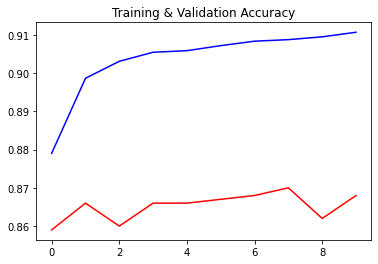

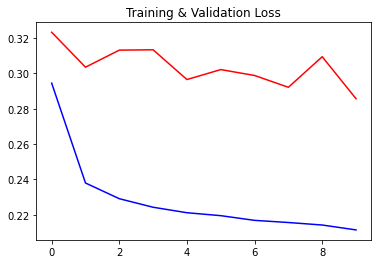

In [41]:
plot_training(history_transfer)

In [42]:
# Load Weights of the Transfer Learning Model
transfer.load_weights('breast_histopathology_transfer_best.hdf5')

In [43]:
# Test Predictions
preds = transfer.predict_generator(test_batches_transfer, steps=len(df_test), verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
   20/10000 [..............................] - 17s 870ms/step


In [44]:
# Take the highest probability scores to get index of predictions for test images
y_pred = np.argmax(preds, axis=1)

# Get labels of test images
y_true = test_batches_transfer.classes

In [45]:
# Evaluate
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_true, y_pred):1.3f}%')

from sklearn.metrics import balanced_accuracy_score
print(f'Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):1.3f}%')
# Balanced accuracy is calculated as the average of the proportion correct of each class individually

Accuracy: 0.871%
Balanced Accuracy: 0.821%


In [46]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix

def matrix():
  conf_matrix = confusion_matrix(y_true, y_pred)
  plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis')
  plt.title('Confusion matrix')
  plt.colorbar()
  tick_marks = np.arange(len(['negative', 'positive']))
  plt.xticks(tick_marks, ['negative', 'positive'])
  plt.yticks(tick_marks, ['negative', 'positive'])
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

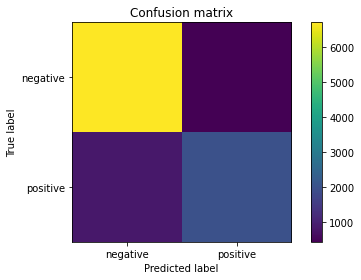

In [47]:
matrix()

In [48]:
confusionmatrix = confusion_matrix(y_true, y_pred)
confusionmatrix

array([[6714,  447],
       [ 841, 1998]])

In [49]:
# Classification Report

from sklearn.metrics import classification_report
report = classification_report(y_true=y_true, y_pred=y_pred, target_names=['negative', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.89      0.94      0.91      7161
    positive       0.82      0.70      0.76      2839

    accuracy                           0.87     10000
   macro avg       0.85      0.82      0.83     10000
weighted avg       0.87      0.87      0.87     10000



Create Train/ Valid/ Test for XGBoost

In [50]:
train_path = 'train_dir'
valid_path = 'val_dir'
test_path = 'test_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
num_test_samples = len(df_test)

train_batch_size = 10000
val_batch_size = 100
test_batch_size = 1000

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [51]:
datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input,
                             horizontal_flip=True,
                             vertical_flip=True, 
                             fill_mode='nearest')

train_batches_transfer = datagen.flow_from_directory(train_path,
                                                     target_size=(image_size, image_size),
                                                     batch_size=train_batch_size)

valid_batches_transfer = datagen.flow_from_directory(valid_path,
                                                     target_size=(image_size, image_size),
                                                     batch_size=val_batch_size)

test_batches_transfer = datagen.flow_from_directory(test_path,
                                                    target_size=(image_size, image_size),
                                                    batch_size=test_batch_size,
                                                    shuffle=False) # test dataset should not be shuffled

Found 383171 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.


In [52]:
X_train, y_train = next(train_batches_transfer)
X_test, y_test = next(test_batches_transfer)
X_val, y_val = next(valid_batches_transfer)

# Applying XGBoost

In [120]:
#Mengambil layer terakhir dari model
model_feat = Model(inputs=transfer.input,outputs=transfer.get_layer

('dense_1').output)

feat_train = model_feat.predict(X_train)
print(feat_train.shape)

feat_test = model_feat.predict(X_test)
print(feat_test.shape)

feat_val = model_feat.predict(X_val)
print(feat_val.shape)


(10000, 2)
(1000, 2)
(100, 2)


In [121]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbc = xgb.XGBClassifier()

xgbc.fit(feat_train,np.argmax(y_train,axis=1))

print('fitting done !!!')

fitting done !!!


In [122]:
print(f'Training Accuracy after XGBoost: {xgbc.score(feat_train,np.argmax(y_train,axis=1)):1.2f}%')


Training Accuracy after XGBoost: 0.91%


In [123]:
print(f'Validation Accuracy after XGBoost: {xgbc.score(feat_val,np.argmax(y_val,axis=1)):1.2f}%')

Validation Accuracy after XGBoost: 0.90%


In [124]:
print(f'Testing Accuracy after XGBoost: {xgbc.score(feat_test,np.argmax(y_test,axis=1)):1.2f}%')

Testing Accuracy after XGBoost: 0.89%


In [125]:
Predxgb = xgbc.predict(feat_train)

In [126]:
from sklearn.metrics import confusion_matrix
pred = transfer.predict(X_train)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_train,axis = 1)

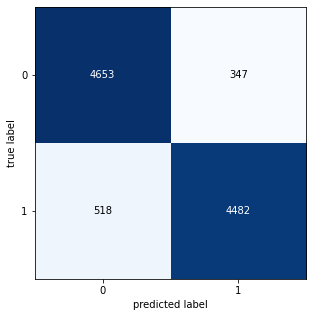

In [127]:
CM = confusion_matrix(y_true, Predxgb)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [128]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, pred, digits=2,  target_names = ["IDC","Non IDC"]))

              precision    recall  f1-score   support

         IDC       0.89      0.94      0.91      5000
     Non IDC       0.94      0.88      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

